
# PSX Stock Price Prediction, Candlesticks, and Investment Simulation

**Models:** LSTM (DL) + RandomForestRegressor (ML baseline)  
**Dataset schema:** `Date, Symbol, Open, High, Low, Close`  



In [80]:
CSV_PATH = "./psx_data_20211210_to_20241210.csv"  
SYMBOL = "OGDC"  # e.g., "WTL", "UBL", "TRG", etc.
DATE_COL = "Date"
CLOSE_COL = "Close"
OHLC_COLS = ["Open", "High", "Low", "Close"]

# Forecast target dates 
FORECAST_DATES_STR = ["2025-06-01", "2025-09-01", "2025-12-01", "2026-06-01"]

# Investment simulation
INVEST_DATE_STR = "2025-06-01"
INVEST_AMOUNT = 10000

# Sliding window
WINDOW_SIZE = 552  # previous days to use as features
TEST_SIZE_RATIO = 0.2  #

RANDOM_STATE = 42

# Create output folders
import os
for d in ["models", "figures", "metrics", "forecasts"]:
    os.makedirs(d, exist_ok=True)


In [3]:
!pip install mplfinance

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

# ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from joblib import dump, load

# DL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Visualization
import mplfinance as mpf
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)


## 1) Load & Clean Data

In [81]:
# Load CSV
df = pd.read_csv(CSV_PATH)

# Basic cleanup
df = df.drop_duplicates()
# Ensure columns exist
required_cols = ["Date", "Symbol", "Open", "High", "Low", "Close"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

# Convert Date
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.dropna(subset=[DATE_COL])

# Filter one symbol
df = df[df["Symbol"] == SYMBOL].copy()
if df.empty:
    raise ValueError(f"No rows found for symbol '{SYMBOL}'. Check the CSV file.")

# Sort by date
df = df.sort_values(DATE_COL).reset_index(drop=True)

# Remove rows with any nulls in OHLC
df = df.dropna(subset=OHLC_COLS)

display(df.head())
print("Rows:", len(df), "| Date range:", df[DATE_COL].min().date(), "to", df[DATE_COL].max().date())


,Date,Symbol,Open,High,Low,Close
0,2021-12-01,OGDC,84.89,84.89,83.45,83.83
1,2021-12-02,OGDC,83.83,83.83,78.76,79.59
2,2021-12-03,OGDC,79.70,80.84,78.60,79.76
3,2021-12-06,OGDC,80.00,81.48,78.75,81.05
4,2021-12-07,OGDC,81.35,86.96,81.35,84.49


Rows: 722 | Date range: 2021-12-01 to 2024-11-29


## 2) Exploratory Visualizations

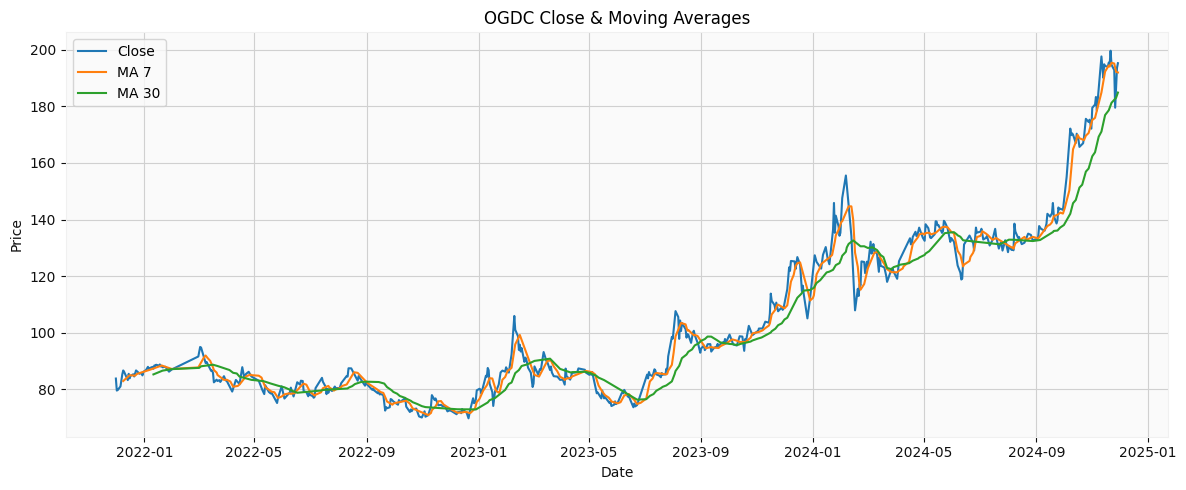

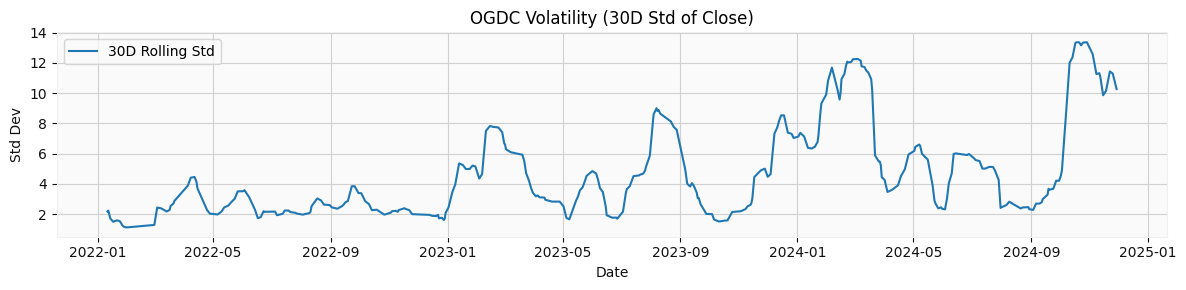

In [82]:
# Moving averages & volatility
df["MA7"] = df[CLOSE_COL].rolling(7).mean()
df["MA30"] = df[CLOSE_COL].rolling(30).mean()
df["Volatility"] = df[CLOSE_COL].rolling(30).std()

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df[DATE_COL], df[CLOSE_COL], label="Close")
ax.plot(df[DATE_COL], df["MA7"], label="MA 7")
ax.plot(df[DATE_COL], df["MA30"], label="MA 30")
ax.set_title(f"{SYMBOL} Close & Moving Averages")
ax.set_xlabel("Date"); ax.set_ylabel("Price")
ax.legend(); plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(df[DATE_COL], df["Volatility"], label="30D Rolling Std")
ax.set_title(f"{SYMBOL} Volatility (30D Std of Close)")
ax.set_xlabel("Date"); ax.set_ylabel("Std Dev")
ax.legend(); plt.tight_layout()
plt.show()


### 2.1 Candlestick Charts (mplfinance & plotly)

In [83]:
# mplfinance candlestick
df_mpf = df.set_index(DATE_COL)[["Open","High","Low","Close"]]
mpf.plot(df_mpf, type="candle", style="yahoo", title=f"{SYMBOL} Candlestick (mplfinance)", figsize=(12,6), mav=(7,30), volume=False, savefig="figures/candlestick_mplfinance.png")

# plotly interactive candlestick
candles = go.Figure(data=[go.Candlestick(x=df[DATE_COL],
                                         open=df["Open"], high=df["High"],
                                         low=df["Low"], close=df["Close"])])
candles.update_layout(title=f"{SYMBOL} Candlestick (plotly)", xaxis_title="Date", yaxis_title="Price")
iplot(candles)


## 3) Feature Engineering: Sliding Windows on Close Price

In [84]:
def make_sequences(series: np.ndarray, window_size: int):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

close_values = df[CLOSE_COL].astype(float).values
X_all, y_all = make_sequences(close_values, WINDOW_SIZE)
print("Sequences:", X_all.shape, y_all.shape)


Sequences: (170, 552) (170,)


In [85]:
split_idx = int(len(X_all) * (1 - TEST_SIZE_RATIO))
X_train, X_test = X_all[:split_idx], X_all[split_idx:]
y_train, y_test = y_all[:split_idx], y_all[split_idx:]

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 136 Test size: 34


## 4) Model 1: RandomForestRegressor (Baseline)

In [86]:
rf = RandomForestRegressor(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1)
# Flatten sequences for RF: (samples, window_size)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# Save model
dump(rf, "models/rf_model.joblib")


['models/rf_model.joblib']

## 5) Model 2: LSTM (Deep Learning)

In [87]:
# Reshape to (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm  = X_test.reshape((X_test.shape[0],  X_test.shape[1],  1))

lstm = Sequential([
    LSTM(64, input_shape=(WINDOW_SIZE,1), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

lstm.compile(optimizer="adam", loss="mse")
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint("models/lstm_model.h5", monitor="val_loss", save_best_only=True)
]
history = lstm.fit(X_train_lstm, y_train, validation_split=0.1, epochs=200, batch_size=32, callbacks=callbacks, verbose=0)

# Predict
lstm_preds = lstm.predict(X_test_lstm).flatten()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step


## 6) Evaluation & Comparison

,Model,MAE,MSE,RMSE,R2
0,RandomForest,27.855786,905.929008,30.098655,-6.638955
1,LSTM,50.295130,2647.982327,51.458550,-21.328260


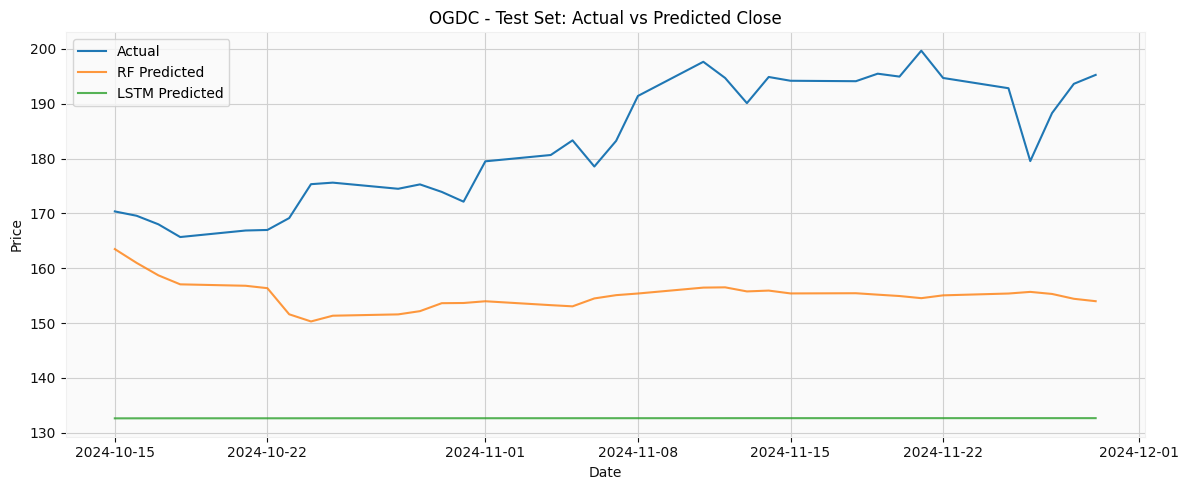

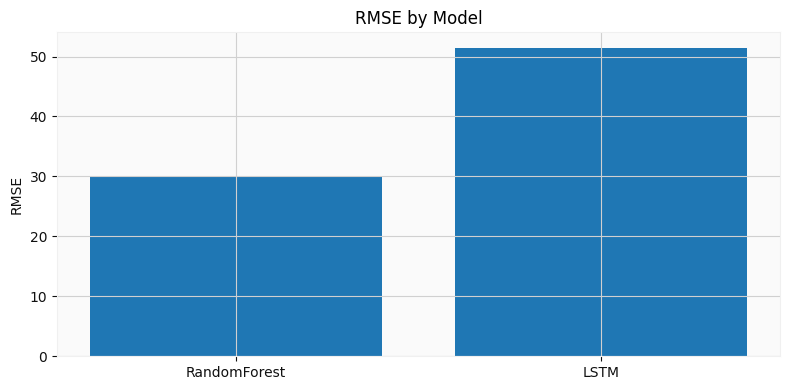

In [88]:
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

metrics = []
for name, preds in [("RandomForest", rf_preds), ("LSTM", lstm_preds)]:
    mae, mse, rmse, r2 = regression_metrics(y_test, preds)
    metrics.append({"Model": name, "MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2})

metrics_df = pd.DataFrame(metrics).sort_values("RMSE")
display(metrics_df)

metrics_df.to_csv("metrics/metrics_comparison.csv", index=False)

# Plot Actual vs Predicted (both models)
test_dates = df[DATE_COL].iloc[len(df)-len(y_test):].values
plt.figure(figsize=(12,5))
plt.plot(test_dates, y_test, label="Actual")
plt.plot(test_dates, rf_preds, label="RF Predicted", alpha=0.8)
plt.plot(test_dates, lstm_preds, label="LSTM Predicted", alpha=0.8)
plt.title(f"{SYMBOL} - Test Set: Actual vs Predicted Close")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(); plt.tight_layout()
plt.savefig("figures/actual_vs_pred.png", dpi=150)
plt.show()

# Error bar chart
plt.figure(figsize=(8,4))
plt.bar(metrics_df["Model"], metrics_df["RMSE"])
plt.title("RMSE by Model")
plt.ylabel("RMSE"); plt.tight_layout()
plt.savefig("figures/rmse_bar.png", dpi=150)
plt.show()


## 7) Forecast Specific Dates & Simulate Investment

In [89]:
# Choose best model by RMSE (lower is better)
best_model_name = metrics_df.iloc[0]["Model"]
print("Best model:", best_model_name)

# Prepare last window from full series
last_window = close_values[-WINDOW_SIZE:].astype(float)

# We will advance day-by-day on business days until we hit each target date.
# For ML model: rf expects shape (1, WINDOW_SIZE)
# For LSTM: expects (1, WINDOW_SIZE, 1)

# Build a business-day date range from last historical date + 1 to max target
target_dates = [pd.to_datetime(d) for d in FORECAST_DATES_STR]
start_date = df[DATE_COL].max() + pd.Timedelta(days=1)
end_date = max(target_dates)
future_bdays = pd.bdate_range(start=start_date, end=end_date)

# Helper to predict next value from current window
def predict_next(window, model_name):
    if model_name == "RandomForest":
        return rf.predict(window.reshape(1, -1))[0]
    else:
        return lstm.predict(window.reshape(1, WINDOW_SIZE, 1), verbose=0).flatten()[0]

# Roll forward
forecast_series = []
cur_window = last_window.copy()
cur_date_map = {}

for d in future_bdays:
    nxt = predict_next(cur_window if best_model_name=="RandomForest" else cur_window.reshape(-1),
                       best_model_name)
    forecast_series.append((d, float(nxt)))
    # update window
    cur_window = np.roll(cur_window, -1)
    cur_window[-1] = nxt
    # capture exact target dates if present as business days
    cur_date_map[d.date()] = float(nxt)

# For any target date that is not a business day, use previous business day forecast
def get_forecast_for_date(target_dt):
    if target_dt.date() in cur_date_map:
        return cur_date_map[target_dt.date()]
    # pick the last business day before target
    prior = pd.bdate_range(end=target_dt, periods=1)[0].date()
    return cur_date_map.get(prior, np.nan)

forecast_table = []
for ds in FORECAST_DATES_STR:
    dt = pd.to_datetime(ds)
    price = get_forecast_for_date(dt)
    forecast_table.append({"Date": dt.date(), "Predicted_Close": price})

forecast_df = pd.DataFrame(forecast_table)
display(forecast_df)
forecast_df.to_csv("forecasts/specific_date_forecasts.csv", index=False)


Best model: RandomForest


,Date,Predicted_Close
0,2025-06-01,161.491225
1,2025-09-01,158.237625
2,2025-12-01,158.185800
3,2026-06-01,158.185800


,Date,Predicted_Close,Shares_Held,Investment_Value,Return_%
0,2025-06-01,161.491225,61.922869,10000.000000,0.000000
1,2025-09-01,158.237625,61.922869,9798.527753,-2.014722
2,2025-12-01,158.185800,61.922869,9795.318600,-2.046814
3,2026-06-01,158.185800,61.922869,9795.318600,-2.046814


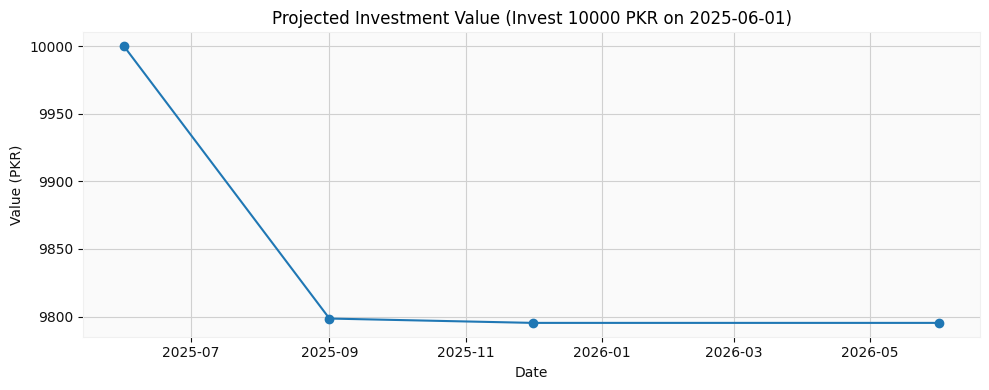

In [90]:
# Simulate investment of INVEST_AMOUNT on INVEST_DATE_STR
invest_dt = pd.to_datetime(INVEST_DATE_STR)
invest_price = None

# If invest date is in history, use actual Close; otherwise forecast
if invest_dt <= df[DATE_COL].max():
    # use previous business day close if invest date is non-business
    if invest_dt not in df[DATE_COL].values:
        invest_dt = pd.bdate_range(end=invest_dt, periods=1)[0]
    invest_price = float(df.loc[df[DATE_COL]==invest_dt, CLOSE_COL].iloc[0])
else:
    # Use forecast for invest date (or nearest prior business day)
    # Build a unified lookup from historical + forecast
    # Use forecast for invest date (or nearest prior business day)
    # Build a unified lookup from historical + forecast
    hist_map = {d: float(p) for d, p in zip(df[DATE_COL].dt.date, df[CLOSE_COL])}

# reuse cur_date_map from forecasts
def get_price_for_date(dt):
    if dt.date() in hist_map:
        return hist_map[dt.date()]
    if dt.date() in cur_date_map:
        return cur_date_map[dt.date()]
    prior = pd.bdate_range(end=dt, periods=1)[0].date()
    return cur_date_map.get(prior, np.nan)

invest_price = get_price_for_date(invest_dt)

shares = INVEST_AMOUNT / invest_price if invest_price and invest_price>0 else np.nan

sim_rows = []
for _, row in forecast_df.iterrows():
    d = pd.to_datetime(row["Date"])
    price = row["Predicted_Close"]
    value = shares * price if price and shares and shares>0 else np.nan
    ret_pct = ((value - INVEST_AMOUNT)/INVEST_AMOUNT)*100 if value else np.nan
    sim_rows.append({"Date": d.date(),
                     "Predicted_Close": price,
                     "Shares_Held": shares,
                     "Investment_Value": value,
                     "Return_%": ret_pct})

sim_df = pd.DataFrame(sim_rows)
display(sim_df)
sim_df.to_csv("forecasts/investment_simulation.csv", index=False)

# Plot investment growth
plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(sim_df["Date"]), sim_df["Investment_Value"], marker="o")
plt.title(f"Projected Investment Value (Invest {INVEST_AMOUNT} PKR on {INVEST_DATE_STR})")
plt.xlabel("Date"); plt.ylabel("Value (PKR)"); plt.tight_layout()
plt.savefig("figures/investment_growth.png", dpi=150)
plt.show()
